# LightGBM

In [5]:
#Setting up enivorment
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier

In [7]:
# 2 load data
df = pd.read_csv("wallacecommunications.csv")
TARGET = "new_contract_this_campaign"

X = df.drop(columns=[TARGET, "ID"], errors="ignore")
y = df[TARGET]

# make sure y is 0/1
if y.dtype == "object":
    y = y.astype(str).str.lower().map({"yes":1, "no":0, "true":1, "false":0, "y":1, "n":0})
y = y.astype(int)

In [8]:
#3 Train/Val/Test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

In [9]:
#4 Preprocess
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=20)),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols),
])

In [29]:
# 5 LightGBM and Hyperparameter tuning

lgbm = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
    verbosity = -1,
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", lgbm),
])

param_dist = {
    "model__n_estimators": [300, 600, 1000],
    "model__learning_rate": [0.02, 0.05, 0.1],
    "model__num_leaves": [15, 31, 63, 127],
    "model__max_depth": [-1, 5, 10, 15],
    "model__min_child_samples": [10, 20, 50, 100],
    "model__subsample": [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__reg_alpha": [0.0, 0.1, 1.0],
    "model__reg_lambda": [0.0, 0.1, 1.0],
}

In [30]:
#6 CV 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=1,
    verbose=1,
    error_score="raise"
)

In [31]:
from time import perf_counter
import joblib
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names*")

t0 = perf_counter()
search.fit(X_train, y_train)
best_lgbm = search.best_estimator_
pd.DataFrame(search.cv_results_).to_csv("LightGMB_cv_results.csv", index=False)
joblib.dump(search.best_estimator_, "best_LightGBM_pipeline.joblib")
t1 = perf_counter()

print(f"Seconds for 5*15 = 75 fits:", t1 - t0)
print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Seconds for 5*15 = 75 fits: 832.8975182999857
Best params: {'model__subsample': 1.0, 'model__reg_lambda': 0.1, 'model__reg_alpha': 1.0, 'model__num_leaves': 127, 'model__n_estimators': 600, 'model__min_child_samples': 50, 'model__max_depth': -1, 'model__learning_rate': 0.02, 'model__colsample_bytree': 0.6}
Best CV ROC-AUC: 0.8471123344475933


In [32]:
# 7 Validation
val_proba = best_lgbm.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)
print("\nValidation ROC-AUC:", roc_auc_score(y_val, val_proba))


Validation ROC-AUC: 0.8550048504175819


In [33]:
#8 Test
best_lgbm.fit(X_trainval, y_trainval)

test_proba = best_lgbm.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

print("\nTEST ROC-AUC:", roc_auc_score(y_test, test_proba))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))


TEST ROC-AUC: 0.8741979465946105
[[7116 1037]
 [ 584 1396]]
              precision    recall  f1-score   support

           0      0.924     0.873     0.898      8153
           1      0.574     0.705     0.633      1980

    accuracy                          0.840     10133
   macro avg      0.749     0.789     0.765     10133
weighted avg      0.856     0.840     0.846     10133


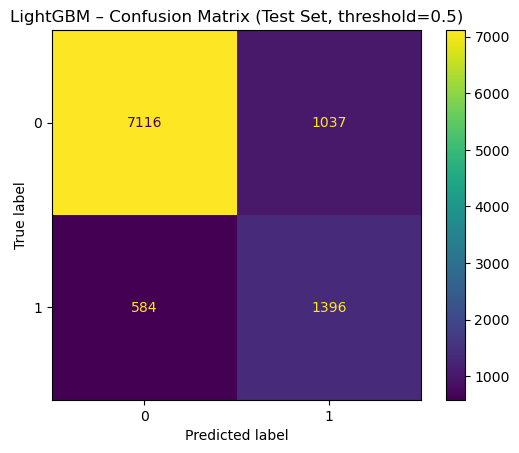

In [34]:
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format="d")
plt.title("LightGBM – Confusion Matrix (Test Set, threshold=0.5)")
plt.show()